In [1]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

import collections
import operator
from numpy.ma.extras import unique

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances

from skmultilearn.problem_transform import LabelPowerset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import zipfile
import re
import os

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) 
from wordcloud import WordCloud
%matplotlib inline
sns.set(rc={'figure.figsize': [20, 15]}, font_scale=1)

2024-04-29 19:49:05.872728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 19:49:05.872878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 19:49:06.028903: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Reading data 

In [2]:
# Specify the directory containing the files
directory_path = '/kaggle/input/reuters21578/reuters21578'

# Get the list of files in the directory
extracted_files = os.listdir(directory_path)

# Print the extracted file names
print("Extracted files:")
for file_name in extracted_files:
    print(file_name)

Extracted files:
reut2-019.sgm
reut2-006.sgm
reut2-017.sgm
reut2-000.sgm
reut2-003.sgm
all-places-strings.lc.txt
reut2-004.sgm
cat-descriptions_120396.txt
reut2-010.sgm
reut2-009.sgm
all-orgs-strings.lc.txt
reut2-021.sgm
reut2-016.sgm
all-exchanges-strings.lc.txt
README.txt
reut2-008.sgm
reut2-013.sgm
reut2-007.sgm
reut2-001.sgm
reut2-012.sgm
reut2-020.sgm
lewis.dtd
all-people-strings.lc.txt
reut2-014.sgm
reut2-018.sgm
feldman-cia-worldfactbook-data.txt
reut2-002.sgm
all-topics-strings.lc.txt
reut2-005.sgm
reut2-015.sgm
reut2-011.sgm


In [3]:
# Load in each data file
text_data = []

print('Loading Files - ', end=' ')
for index in range(22):
    print(index, end=' ')
    filename = '/kaggle/input/reuters21578/reuters21578/reut2-{0}.sgm'.format(str(index).zfill(3))
    with open(filename, 'r', encoding = 'utf-8', errors = 'ignore') as infile:
        text_data.append(infile.read())

print()
print('Loading Files - Done')

Loading Files -  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
Loading Files - Done


# Extracting features based on readme file

In [4]:
# Separate each text file into articles

print('Converting Files to Articles - ', end='')
i, counter = 0, 0

columns = ['title','reuters_topic','date', 'topics', 'article','places','people','orgs','exchanges','companies','dateline','author','type']
index = [x for x in range(0, 21578)]
df = pd.DataFrame(columns=columns, index=index)

for textfile in text_data:
    print(i, end=' ')
    # Parse text as html
    soup = BeautifulSoup(textfile, 'html.parser')
    
    # Extract article between <BODY> and </BODY> and convert to standard text. Add to list of articles
    topics = soup.find_all('topics')
    places = soup.find_all('places')
    people = soup.find_all('people')
    orgs = soup.find_all('orgs')
    exchanges = soup.find_all('exchanges')
    companies = soup.find_all('companies')
    dateline = soup.find_all('dateline')
    author = soup.find_all('author')
    j=0
    for document in soup.find_all('reuters'): 
        
        title_tag = document.find('title')
        if title_tag:
            df.loc[counter, 'title'] = title_tag.get_text().lower()
        else:
            df.loc[counter, 'title'] = np.nan
            
        type_tag = document.find('text').get('type')   
        if type_tag:
            df.loc[counter, 'type'] = type_tag.lower()
        else:
            df.loc[counter, 'type'] = 'norm'     

        dateline_tag = document.find('dateline')
        if dateline_tag:
            df.loc[counter, 'dateline'] = dateline_tag.get_text().lower()
        else:
            df.loc[counter, 'dateline'] = np.nan    
        
        date_tag = document.find('date')
        if date_tag:
            df.loc[counter, 'date'] = date_tag.get_text()
        else:
            df.loc[counter, 'date'] = np.nan         
        
        body_tag = document.find('body')
        if body_tag:
            df.loc[counter, 'article'] = body_tag.get_text()
        else:
            df.loc[counter, 'article'] = np.nan
            
        author_tag = document.find('author')
        if author_tag:
            df.loc[counter, 'author'] = author_tag.get_text().lower()
        else:
            df.loc[counter, 'author'] = np.nan   
        
        if not places[j].find_all('d'):
            df['places'][counter] = np.nan
        else:
            df['places'][counter] = places[j].find_all('d')
    
        if not people[j].find_all('d'):
            df['people'][counter] = np.nan
        else:
            df['people'][counter] = people[j].find_all('d')
    
        if not orgs[j].find_all('d'):
            df['orgs'][counter] = np.nan
        else:
            df['orgs'][counter] = orgs[j].find_all('d')
    
        if not exchanges[j].find_all('d'):
            df['exchanges'][counter] = np.nan
        else:
            df['exchanges'][counter] = exchanges[j].find_all('d')
    
        if not companies[j].find_all('d'):
            df['companies'][counter] = np.nan
        else:
            df['companies'][counter] = companies[j].find_all('d')
    
        if not topics[j].find_all('d'):
            df['topics'][counter] = np.nan
        else:
            df['topics'][counter] = topics[j].find_all('d')
        
        df['reuters_topic'][counter] = document.get('topics', '').lower()
        j += 1
        counter += 1
    
    i += 1

print()
print('Files to Aritcle Conversion - Done')
print('Total Articles - ', counter)

Converting Files to Articles - 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
Files to Aritcle Conversion - Done
Total Articles -  21578


In [5]:
df.head()

,title,reuters_topic,date,topics,article,places,people,orgs,exchanges,companies,dateline,author,type
0,bahia cocoa review,yes,26-FEB-1987 15:01:01.79,[[cocoa]],Showers continued throughout the week in\nthe ...,"[[el-salvador], [usa], [uruguay]]",NaN,NaN,NaN,NaN,"salvador, feb 26 -",NaN,norm
1,standard oil <srd> to form financial unit,no,26-FEB-1987 15:02:20.00,NaN,Standard Oil Co and BP North America\nInc said...,[[usa]],NaN,NaN,NaN,NaN,"cleveland, feb 26 -",NaN,norm
2,texas commerce bancshares <tcb> files plan,no,26-FEB-1987 15:03:27.51,NaN,Texas Commerce Bancshares Inc's Texas\nCommerc...,[[usa]],NaN,NaN,NaN,NaN,"houston, feb 26 -",NaN,norm
3,talking point/bankamerica <bac> equity offer,no,26-FEB-1987 15:07:13.72,NaN,BankAmerica Corp is not under\npressure to act...,"[[usa], [brazil]]",NaN,NaN,NaN,NaN,"los angeles, feb 26 -","by janie gabbett, reuters",norm
4,national average prices for farmer-owned reserve,yes,26-FEB-1987 15:10:44.60,"[[grain], [wheat], [corn], [barley], [oat], [s...",The U.S. Agriculture Department\nreported the ...,[[usa]],NaN,NaN,NaN,NaN,"washington, feb 26 -",NaN,norm


In [6]:
df.shape

(21578, 13)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21578 entries, 0 to 21577
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          20841 non-null  object
 1   reuters_topic  21578 non-null  object
 2   date           21578 non-null  object
 3   topics         11367 non-null  object
 4   article        19043 non-null  object
 5   places         18798 non-null  object
 6   people         1156 non-null   object
 7   orgs           881 non-null    object
 8   exchanges      482 non-null    object
 9   companies      0 non-null      object
 10  dateline       19043 non-null  object
 11  author         875 non-null    object
 12  type           21578 non-null  object
dtypes: object(13)
memory usage: 2.8+ MB


# Data preproccessing & understanding

according to the README information provided. 

the conditions mentioned:

    1-If the 'REUTERS TOPICS' attribute contains 'YES' but no topics are given in the 'TOPICS' field, then those 
    entries can reasonably be considered negative examples for all 135 topics. As a result, these entries should be retained in your dataset.

    2-If the 'REUTERS TOPICS' attribute contains 'NO' but some topics are given in the 'TOPICS' field, it indicates 
    that the topics were added after the original indexing. In this case, these entries should also be retained in your dataset.

    3- if the 'REUTERS TOPICS' attribute contains 'NO' and no topics are given in the 'TOPICS' field, it is ambiguous 
    whether these entries were intended as negative examples or not. In this situation, the README suggests dismissing these entries from the dataset.
    
    4-if the 'REUTERS TOPICS' attribute contains 'BYPASS' indicates that  the story was marked with the string 
    "bypass" (or a typographical variant on that string).
     This poorly-named attribute unfortunately is the subject of much confusion

In [8]:
# get rid of ambiguous data
df.drop(df[(df['reuters_topic'] == 'no') & (df['topics'].isnull())].index, inplace=True)
df.drop(df[df['reuters_topic'] == 'bypass'].index, inplace=True)

In [9]:
df.shape

(13484, 13)

In [10]:
df.isna().sum()

title               69
reuters_topic        0
date                 0
topics            2117
article           1132
places             880
people           12798
orgs             12801
exchanges        13384
companies        13484
dateline          1132
author           12895
type                 0
dtype: int64

In [11]:
# Replace empty 'topics' values with corresponding 'title' values
df['article'].fillna(df['title'], inplace=True)

# Treat missing data 
## Drop columns that have more than 30% of NANs

In [12]:
# Calculate the percentage of NaN values in each column
nan_percentages = (df.isnull().sum() / len(df)) * 100

# Print the percentage of NaN values for each column
print(nan_percentages)

title              0.511718
reuters_topic      0.000000
date               0.000000
topics            15.700089
article            0.511718
places             6.526253
people            94.912489
orgs              94.934737
exchanges         99.258380
companies        100.000000
dateline           8.395135
author            95.631860
type               0.000000
dtype: float64


In [13]:
# Drop columns with a NaN percentage above the threshold (30%), excluding 'topics'
threshold = 30
columns_to_drop = nan_percentages[nan_percentages > threshold].index
# Drop the selected columns
df.drop(columns_to_drop, axis=1, inplace=True)

In [14]:
# check negative classes
negative_classes = df.loc[(df['topics'].isnull()) & (df['reuters_topic'] == 'yes')]
print(len(negative_classes))

2117


In [15]:
df = df.drop('reuters_topic',axis=1)

# Feature engeneering

In [16]:
# return topics as lists
df.loc[df['topics'].isnull(),['topics']] = df.loc[df['topics'].isnull(),'topics'].apply(lambda x: ['Unknown'])

In [17]:
# Define the custom date format to match your date format
date_format = '%d-%b-%Y %H:%M:%S.%f'

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], format=date_format, errors='coerce')

In [18]:
df.tail()

,title,date,topics,article,places,dateline,type
21570,n.z.'s chase corp makes offer for entregrowth,1987-10-19 01:35:27.640,[[acq]],Chase Corp Ltd <CHCA.WE> said it will\nmake an...,[[new-zealand]],"wellington, oct 19 -",norm
21572,tokyo dealers see dollar poised to breach 140 yen,1987-10-19 00:59:58.560,"[[money-fx], [dlr], [yen]]",Tokyo's foreign exchange market is watching\nn...,"[[japan], [west-germany], [usa]]","tokyo, oct 19 -",norm
21573,japan/india conference cuts gulf war risk charges,1987-10-19 00:34:08.940,[[ship]],The Japan/India-Pakistan-Gulf/Japan\nshipping ...,"[[hong-kong], [japan], [india], [pakistan], [i...","hong kong, oct 19 -",norm
21574,soviet industrial growth/trade slower in 1987,1987-10-19 00:18:22.790,[[ipi]],The Soviet Union's industrial output is\ngrowi...,[[ussr]],"moscow, oct 19 -",norm
21575,six killed in south african gold mine accident,1987-10-19 00:05:11.260,[[gold]],Six black miners have been killed\nand two inj...,[[south-africa]],"johannesburg, oct 19 -",norm


In [19]:
df.dropna(inplace=True)

In [20]:
df.isna().sum()

title       0
date        0
topics      0
article     0
places      0
dateline    0
type        0
dtype: int64

In [21]:
df.shape

(12067, 7)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12067 entries, 0 to 21575
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     12067 non-null  object        
 1   date      12067 non-null  datetime64[ns]
 2   topics    12067 non-null  object        
 3   article   12067 non-null  object        
 4   places    12067 non-null  object        
 5   dateline  12067 non-null  object        
 6   type      12067 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 754.2+ KB


In [23]:
df.head()

,title,date,topics,article,places,dateline,type
0,bahia cocoa review,1987-02-26 15:01:01.790,[[cocoa]],Showers continued throughout the week in\nthe ...,"[[el-salvador], [usa], [uruguay]]","salvador, feb 26 -",norm
4,national average prices for farmer-owned reserve,1987-02-26 15:10:44.600,"[[grain], [wheat], [corn], [barley], [oat], [s...",The U.S. Agriculture Department\nreported the ...,[[usa]],"washington, feb 26 -",norm
5,argentine 1986/87 grain/oilseed registrations,1987-02-26 15:14:36.410,"[[veg-oil], [linseed], [lin-oil], [soy-oil], [...",Argentine grain board figures show\ncrop regis...,[[argentina]],"buenos aires, feb 26 -",norm
7,usx <x> debt dowgraded by moody's,1987-02-26 15:15:40.120,[Unknown],Moody's Investors Service Inc said it\nlowered...,[[usa]],"new york, feb 26 -",norm
8,champion products <ch> approves stock split,1987-02-26 15:17:11.200,[[earn]],Champion Products Inc said its\nboard of direc...,[[usa]],"rochester, n.y., feb 26 -",norm


In [24]:
# Extract the 'city' portion with or without a comma and optional space
df['city'] = df['dateline'].str.extract(r'([^,]+)(?:,\s*|$)')

# Display the 'city' column
print(df['city'])

0                salvador
4              washington
5            buenos aires
7                new york
8               rochester
               ...       
21570          wellington
21572               tokyo
21573           hong kong
21574              moscow
21575        johannesburg
Name: city, Length: 12067, dtype: object


In [25]:
df['city'] = df['city'].str.strip()  # Remove leading and trailing spaces
df['city'] = df['city'].str.replace(r'[^\w\s]', '', regex=True)  # Remove special characters

# You can also convert all letters to lowercase for consistency
df['city'] = df['city'].str.lower()

# replace multiple spaces with a single space:
df['city'] = df['city'].str.replace(r'\s+', ' ')

In [26]:
print(df['city'].value_counts())

city
new york       1513
washington     1207
london         1008
tokyo           423
chicago         285
               ... 
wausau            1
cheverly          1
paramaribo        1
harrodsburg       1
maumee            1
Name: count, Length: 1134, dtype: int64


In [27]:
ind = df['city'].value_counts(dropna=False).keys().tolist()
val = df['city'].value_counts(dropna=False).tolist()
value_dict = list(zip(ind, val))

In [28]:
lc_sm = []
y = 'Less'
for val,ind in value_dict:
    if ind <= 5:
        lc_sm.append(val)
    else :
        pass
def lcdlt(x):
    if x in lc_sm:
        return y
    else :
        return x

In [29]:
df['city'] = df['city'].apply(lcdlt)

In [30]:
df=df.drop(df[(df['city']=='Less')].index)
df=df.drop('dateline',axis=1)

In [31]:
print(df['city'].value_counts())

city
new york      1513
washington    1207
london        1008
tokyo          423
chicago        285
              ... 
waterbury        6
el paso          6
horsham          6
scottsdale       6
princeton        6
Name: count, Length: 245, dtype: int64


In [32]:
df.shape

(10419, 7)

In [33]:
df.head()

,title,date,topics,article,places,type,city
4,national average prices for farmer-owned reserve,1987-02-26 15:10:44.600,"[[grain], [wheat], [corn], [barley], [oat], [s...",The U.S. Agriculture Department\nreported the ...,[[usa]],norm,washington
5,argentine 1986/87 grain/oilseed registrations,1987-02-26 15:14:36.410,"[[veg-oil], [linseed], [lin-oil], [soy-oil], [...",Argentine grain board figures show\ncrop regis...,[[argentina]],norm,buenos aires
7,usx <x> debt dowgraded by moody's,1987-02-26 15:15:40.120,[Unknown],Moody's Investors Service Inc said it\nlowered...,[[usa]],norm,new york
8,champion products <ch> approves stock split,1987-02-26 15:17:11.200,[[earn]],Champion Products Inc said its\nboard of direc...,[[usa]],norm,rochester
11,ohio mattress <omt> may have lower 1st qtr net,1987-02-26 15:19:15.450,"[[earn], [acq]]","Ohio Mattress Co said its first\nquarter, endi...",[[usa]],norm,cleveland


In [34]:
# Count the occurrences of each city
city_counts = df['city'].value_counts().reset_index()
city_counts.columns = ['City', 'Count']
# Create a treemap
fig = px.treemap(city_counts, path=[px.Constant("all"),'City'], values='Count')
fig.update_traces(root_color="lightgrey")
# Adjust the figure size to take all available space
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
pio.write_html(fig,file="fig1.html",auto_open=True)
fig.show()

##  Get rid of problematic strings

In [35]:
# Define a function for cleaning
def clean_text(text):
    # Strip leading and trailing spaces
    text = text.strip()
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove digits followed by a semicolon
    text = re.sub(r'\d*;', ' ', text)
    # Replace newline characters with spaces
    text = text.replace("\n", " ")
    # Handle cases with forward slashes
    text = re.sub(r'(\w+)/(\w+)', r'\1 \2', text)
    return text

In [36]:
# Apply the cleaning function to 'title' and 'description' columns
df[['title', 'article']] = df[['title', 'article']].applymap(clean_text)

In [37]:
# Reset the index
df.reset_index(drop=True, inplace=True)
df.head()

,title,date,topics,article,places,type,city
0,national average prices for farmer-owned reserve,1987-02-26 15:10:44.600,"[[grain], [wheat], [corn], [barley], [oat], [s...",The U.S. Agriculture Department reported the f...,[[usa]],norm,washington
1,argentine 1986 87 grain oilseed registrations,1987-02-26 15:14:36.410,"[[veg-oil], [linseed], [lin-oil], [soy-oil], [...",Argentine grain board figures show crop regist...,[[argentina]],norm,buenos aires
2,usx debt dowgraded by moody's,1987-02-26 15:15:40.120,[Unknown],Moody's Investors Service Inc said it lowered ...,[[usa]],norm,new york
3,champion products approves stock split,1987-02-26 15:17:11.200,[[earn]],Champion Products Inc said its board of direct...,[[usa]],norm,rochester
4,ohio mattress may have lower 1st qtr net,1987-02-26 15:19:15.450,"[[earn], [acq]]","Ohio Mattress Co said its first quarter, endin...",[[usa]],norm,cleveland


In [38]:
df['type'].value_counts()

type
norm    10419
Name: count, dtype: int64

In [39]:
# All data have same type
df = df.drop('type',axis=1)

In [40]:
#nltk.download('stopwords')

# NLP

In [41]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stopwords, punctuation, and digits
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

In [42]:
df[['title', 'article']] = df[['title', 'article']].applymap(preprocess_text)

In [43]:
df.columns

Index(['title', 'date', 'topics', 'article', 'places', 'city'], dtype='object')

In [44]:
df.describe(include=['O']).T

,count,unique,top,freq
title,10419,9582,year net,46
topics,10419,607,[[earn]],2685
article,10419,9964,qtli div ct vs ct prior pay april record march...,24
places,10419,807,[[usa]],5254
city,10419,245,new york,1513


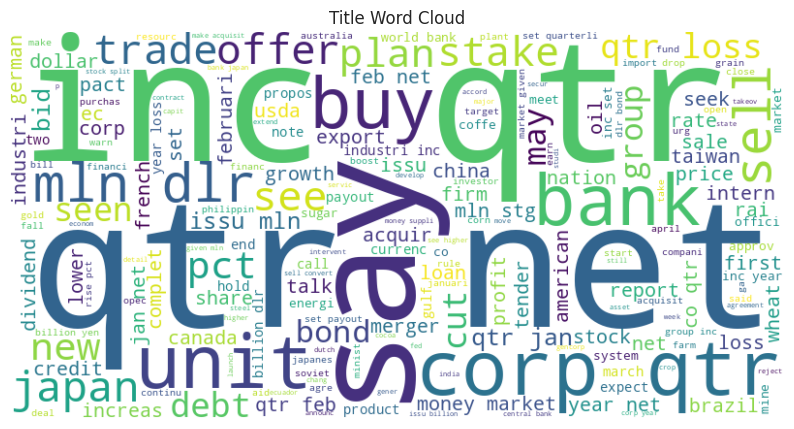

In [45]:
#Word clouds provide a visual representation of the most frequently occurring words in a text corpus. 
#The size of each word is proportional to its frequency.
# Generate word cloud for titles
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['title']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Title Word Cloud')
plt.show()

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10419 entries, 0 to 10418
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    10419 non-null  object        
 1   date     10419 non-null  datetime64[ns]
 2   topics   10419 non-null  object        
 3   article  10419 non-null  object        
 4   places   10419 non-null  object        
 5   city     10419 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 488.5+ KB


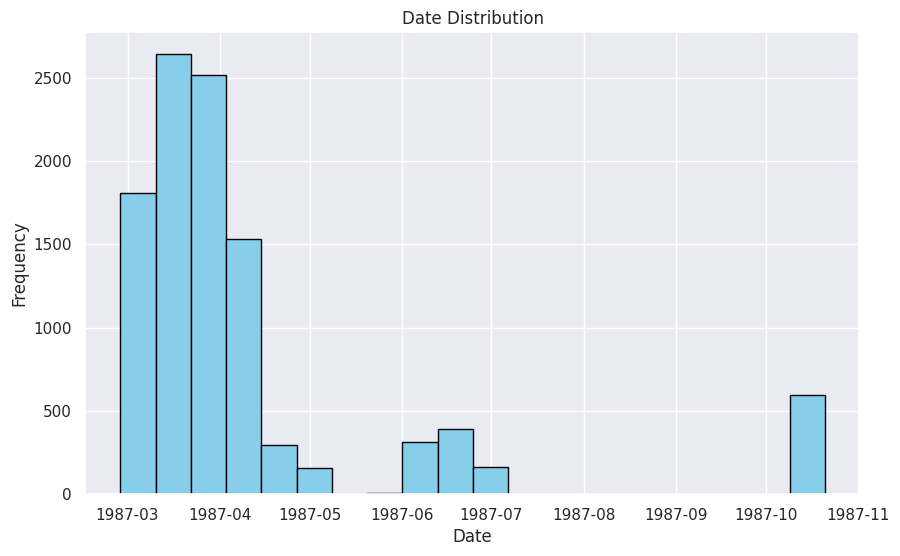

In [47]:
# Convert 'date' column to datetime format (if not already)
df['date'] = pd.to_datetime(df['date'])

# Visualize the distribution of dates
plt.figure(figsize=(10, 6))
df['date'].hist(bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Date Distribution')
plt.show()

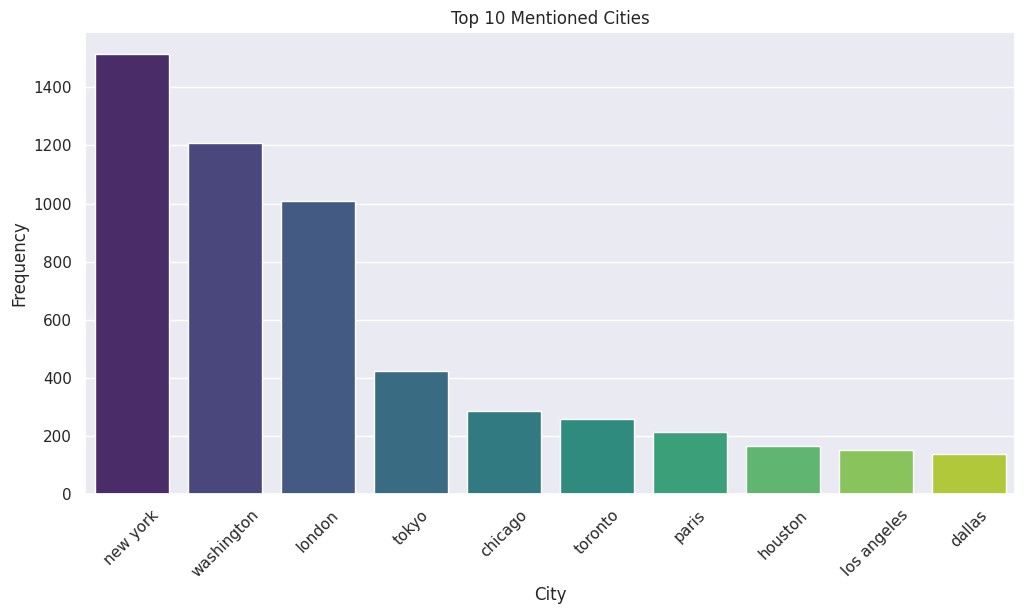

In [48]:
# Get the top N cities
top_cities = df['city'].value_counts().nlargest(10)

# Visualize the top cities
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.index, y=top_cities.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 10 Mentioned Cities')
plt.xlabel('City')
plt.ylabel('Frequency')
plt.show()

In [49]:
all_text = df[['title', 'article']]
all_text

,title,article
0,nation averag price reserv,agricultur depart report reserv nation averag ...
1,argentin grain oilse registr,argentin grain board figur show crop registr g...
2,usx debt dowgrad moodi,moodi investor servic inc said lower debt pref...
3,champion product approv stock split,champion product inc said board director appro...
4,ohio mattress may lower qtr net,ohio mattress co said first quarter end februa...
...,...,...
10414,chase corp make offer entregrowth,chase corp ltd said make offer share option al...
10415,tokyo dealer see dollar pois breach yen,tokyo foreign exchang market watch nervous see...
10416,japan india confer cut gulf war risk charg,japan japan ship confer said would cut extra r...
10417,soviet industri growth trade slower,soviet union industri output grow slower pace ...


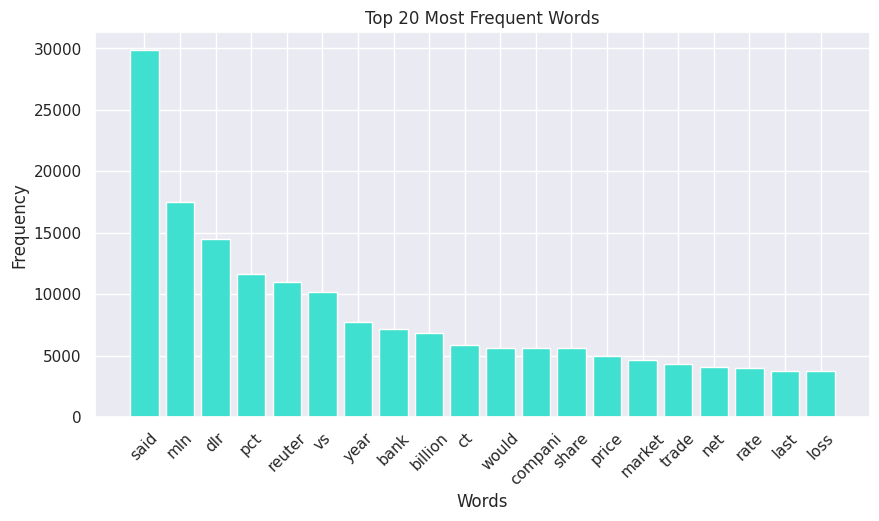

In [50]:
# Combine all articles into a single string
all_text = ' '.join(df['article'])

# Calculate word frequencies
word_frequencies = Counter(all_text.split())

# Create a bar chart for the top N words
top_n = 20
top_words = [word[0] for word in word_frequencies.most_common(top_n)]
word_counts = [word[1] for word in word_frequencies.most_common(top_n)]

plt.figure(figsize=(10, 5))
plt.bar(top_words, word_counts, color='turquoise')
plt.title(f'Top {top_n} Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Dissimilarity Matrix

In [51]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply TF-IDF vectorization to the articles
tfidf_matrix = tfidf_vectorizer.fit_transform(df['article'])

# Compute cosine distances
dissimilarity_matrix = cosine_distances(tfidf_matrix)
# Now dissimilarity_matrix contains the dissimilarity values

In [52]:
dissimilarity_matrix

array([[0.        , 0.96513472, 0.98549862, ..., 0.99955714, 0.99336496,
        0.99964392],
       [0.96513472, 0.        , 0.99456849, ..., 0.99090483, 0.97030584,
        0.99983161],
       [0.98549862, 0.99456849, 0.        , ..., 0.99489948, 0.97365689,
        0.98625823],
       ...,
       [0.99955714, 0.99090483, 0.99489948, ..., 0.        , 0.95458349,
        0.97939808],
       [0.99336496, 0.97030584, 0.97365689, ..., 0.95458349, 0.        ,
        0.99433954],
       [0.99964392, 0.99983161, 0.98625823, ..., 0.97939808, 0.99433954,
        0.        ]])

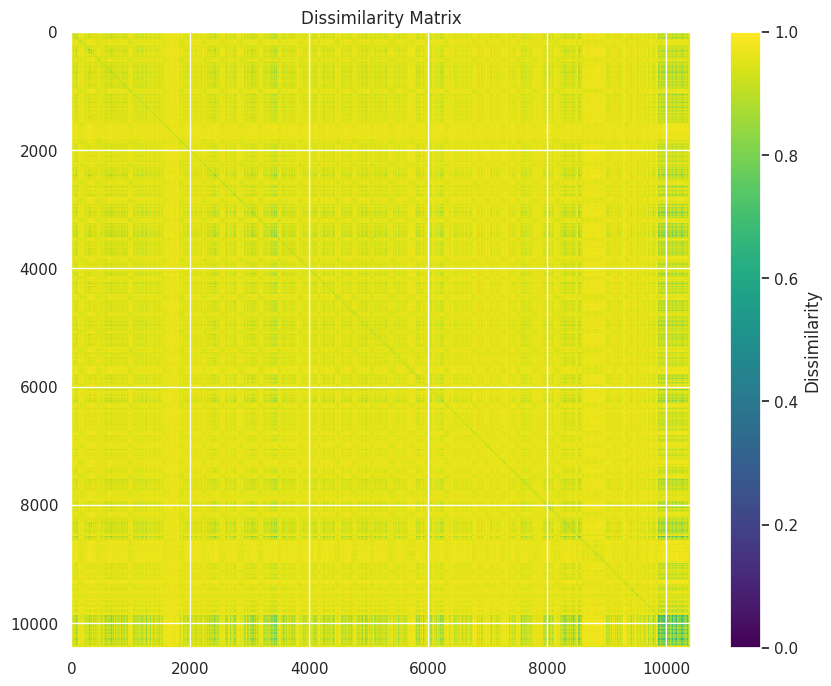

In [53]:
plt.figure(figsize=(10, 8))
plt.imshow(dissimilarity_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Dissimilarity')
plt.title('Dissimilarity Matrix')
plt.show()

In [54]:
df.head()

,title,date,topics,article,places,city
0,nation averag price reserv,1987-02-26 15:10:44.600,"[[grain], [wheat], [corn], [barley], [oat], [s...",agricultur depart report reserv nation averag ...,[[usa]],washington
1,argentin grain oilse registr,1987-02-26 15:14:36.410,"[[veg-oil], [linseed], [lin-oil], [soy-oil], [...",argentin grain board figur show crop registr g...,[[argentina]],buenos aires
2,usx debt dowgrad moodi,1987-02-26 15:15:40.120,[Unknown],moodi investor servic inc said lower debt pref...,[[usa]],new york
3,champion product approv stock split,1987-02-26 15:17:11.200,[[earn]],champion product inc said board director appro...,[[usa]],rochester
4,ohio mattress may lower qtr net,1987-02-26 15:19:15.450,"[[earn], [acq]]",ohio mattress co said first quarter end februa...,[[usa]],cleveland


In [55]:
# making a copy of the data frame before revoming the article and topics from it , for the ML model
df_for_ML= df.drop(['title','date', 'places', 'city'],axis=1)
df_for_ML.head()

,topics,article
0,"[[grain], [wheat], [corn], [barley], [oat], [s...",agricultur depart report reserv nation averag ...
1,"[[veg-oil], [linseed], [lin-oil], [soy-oil], [...",argentin grain board figur show crop registr g...
2,[Unknown],moodi investor servic inc said lower debt pref...
3,[[earn]],champion product inc said board director appro...
4,"[[earn], [acq]]",ohio mattress co said first quarter end februa...


# CountVectorizer

In [56]:
def count_vectorize(text):
    # Create an instance of CountVectorizer
    vectorizer = CountVectorizer()
    # Fit_transform the text_series
    X = vectorizer.fit_transform(text)
    # Convert the resulting matrix to a DataFrame
    df_processed = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    return df_processed

In [57]:
title_data = count_vectorize(df['title'])
article_data = count_vectorize(df['article'])
df = df.drop(['title','article'],axis=1)
# Concatenate df with text
text_data = pd.concat([title_data, article_data], axis=1)

In [58]:
text_data.columns

Index(['aaa', 'aancor', 'aaron', 'ab', 'abat', 'abbett', 'abbey', 'abc',
       'abex', 'abm',
       ...
       'zoran', 'zorinski', 'zuccherifici', 'zuckerman', 'zuercher', 'zuheir',
       'zulia', 'zurich', 'zverev', 'zwermann'],
      dtype='object', length=24157)

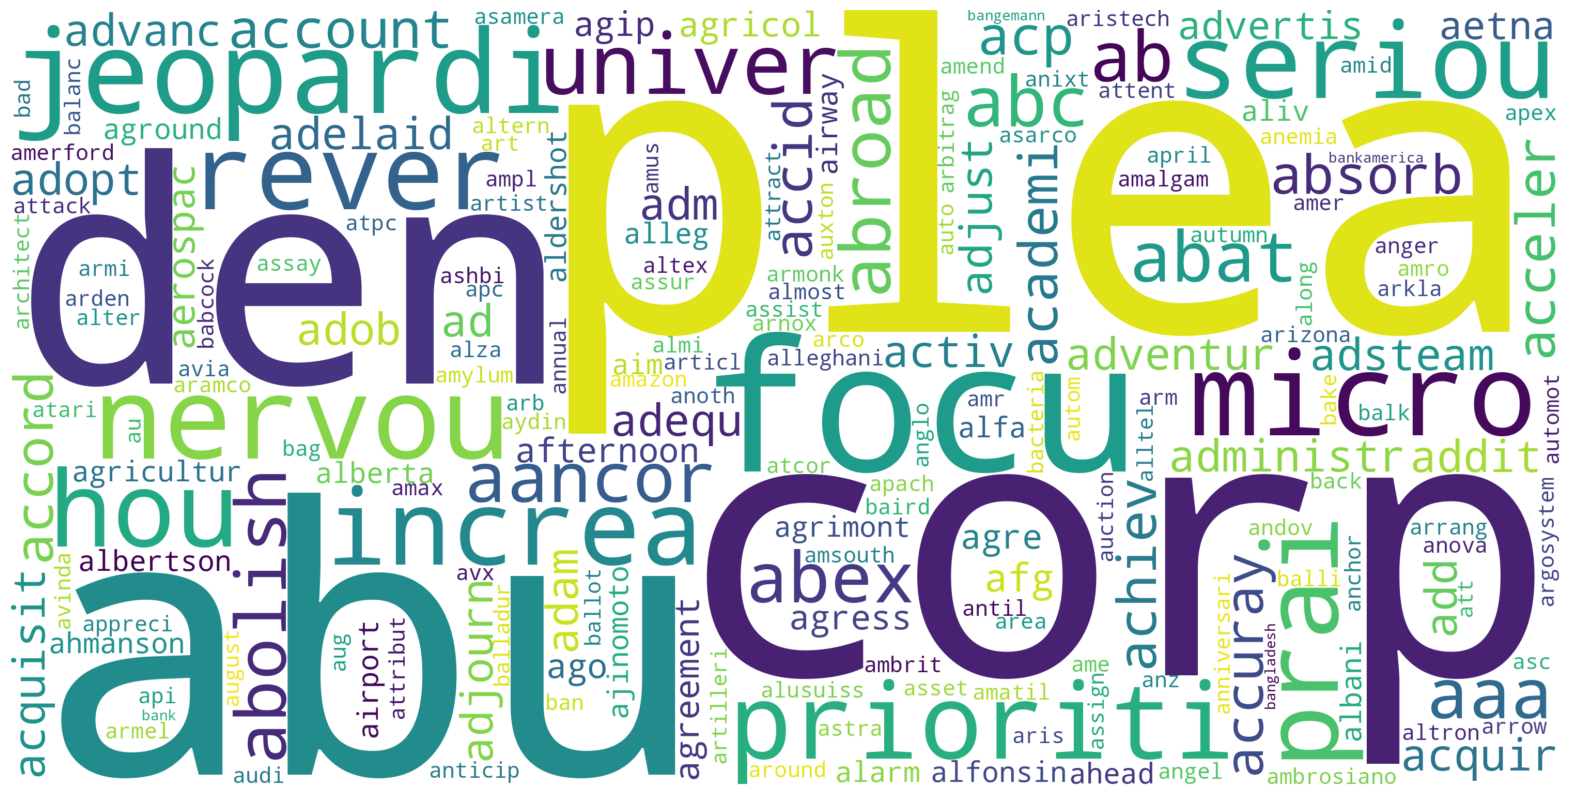

In [59]:
cloud = text_data.columns.values.tolist()
text = ' '.join(cloud)

wordcloud = WordCloud(width=3000, height=1500, background_color='white').generate(text)

# Generate word cloud using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [60]:
text_data.head()

,aaa,aancor,aaron,ab,abat,abbett,abbey,abc,abex,abm,...,zoran,zorinski,zuccherifici,zuckerman,zuercher,zuheir,zulia,zurich,zverev,zwermann
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
target = df['topics']
df = df.drop('topics',axis=1)

In [62]:
df.columns

Index(['date', 'places', 'city'], dtype='object')

In [63]:
target

0        [[grain], [wheat], [corn], [barley], [oat], [s...
1        [[veg-oil], [linseed], [lin-oil], [soy-oil], [...
2                                                [Unknown]
3                                                 [[earn]]
4                                          [[earn], [acq]]
                               ...                        
10414                                              [[acq]]
10415                           [[money-fx], [dlr], [yen]]
10416                                             [[ship]]
10417                                              [[ipi]]
10418                                             [[gold]]
Name: topics, Length: 10419, dtype: object

In [64]:
# Function to remove HTML tags from a string
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Function to remove HTML tags from a nested list
# Remove HTML tags from the list of lists
clean_topics = []
for sublist in target.to_list():
    clean_sublist = []
    for item in sublist:
        clean_sublist.append(remove_html_tags(str(item)))
    clean_topics.append(clean_sublist)

In [65]:
# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# Perform one-hot encoding
topics = mlb.fit_transform(clean_topics)
# Create a new DataFrame with the encoded countries
y = pd.DataFrame(topics, columns=mlb.classes_)
y.head()

,Unknown,acq,alum,austdlr,barley,bfr,bop,can,carcass,castor-oil,...,tapioca,tea,tin,trade,veg-oil,wheat,wool,wpi,yen,zinc
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
rowSums = y.sum(axis=1)
multiLabel_counts = rowSums.value_counts().iloc[1:]
print('number of lables for each article\n',rowSums,'\n')
print('number of articles have multilabel\n',multiLabel_counts)

number of lables for each article
 0         6
1        12
2         1
3         1
4         2
         ..
10414     1
10415     3
10416     1
10417     1
10418     1
Length: 10419, dtype: int64 

number of articles have multilabel
 2     1110
3      276
4       92
5       51
6       30
7        8
8        6
9        6
10       4
12       2
14       2
11       2
16       1
Name: count, dtype: int64


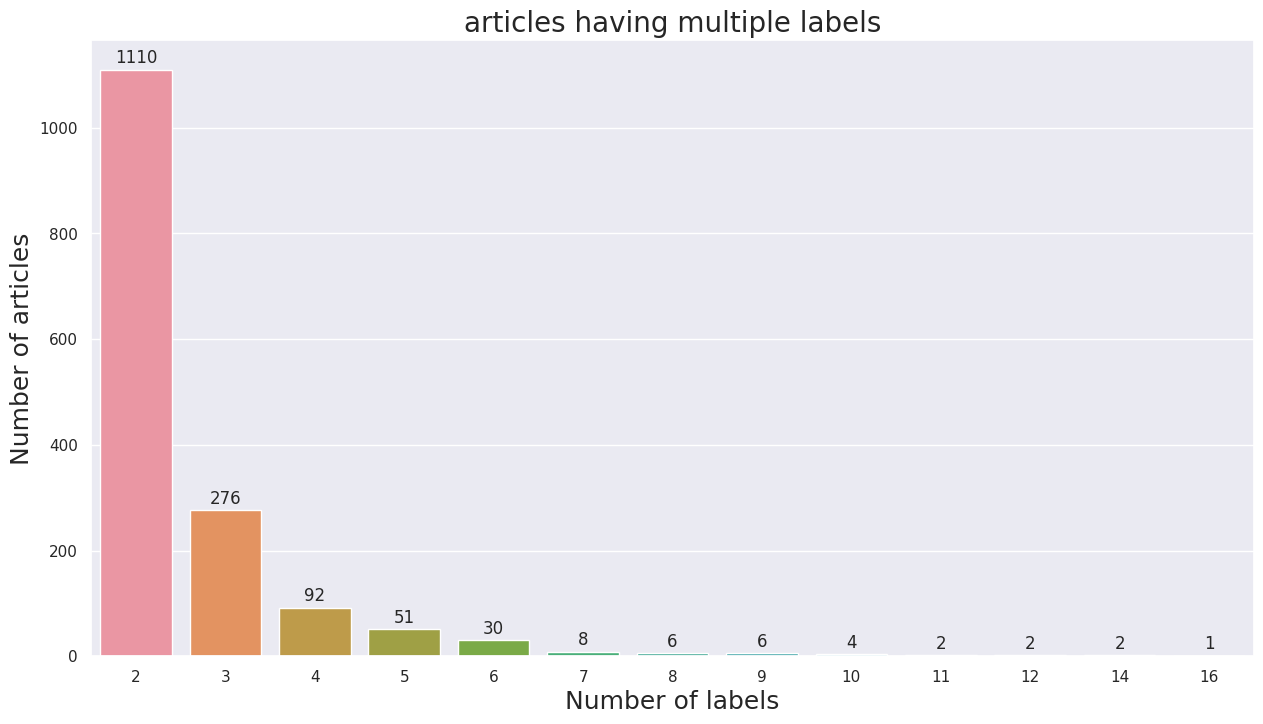

In [67]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)
plt.title("articles having multiple labels", fontsize=20)
plt.ylabel('Number of articles', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

# Adding the text labels
rects = ax.patches
labels = multiLabel_counts.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

plt.show()

# One-hot encoding

In [68]:
# Extract the column as a list of lists
countries = df['places'].tolist()

# Remove HTML tags from the list of lists
clean_countries = []
for sublist in countries:
    clean_sublist = []
    for item in sublist:
        clean_sublist.append(remove_html_tags(str(item)))
    clean_countries.append(clean_sublist)

In [69]:
# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# Perform one-hot encoding
encoded_countries = mlb.fit_transform(clean_countries)
# Create a new DataFrame with the encoded countries
encoded_countries = pd.DataFrame(encoded_countries, columns=mlb.classes_)

In [70]:
encoded_countries.head()

,algeria,argentina,australia,austria,bahrain,bangladesh,barbados,belgium,benin,bermuda,...,vanuatu,venezuela,vietnam,west-germany,yemen-arab-republic,yemen-demo-republic,yugoslavia,zaire,zambia,zimbabwe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
country_counts = encoded_countries.sum().sort_values(ascending=False)
for country, count in country_counts.items():
    print(country,count)

usa 6332
uk 1098
canada 712
japan 687
west-germany 358
france 283
brazil 244
australia 194
ussr 138
belgium 135
china 135
switzerland 134
netherlands 122
taiwan 101
philippines 96
italy 95
iran 93
hong-kong 87
new-zealand 81
indonesia 81
south-korea 78
spain 77
argentina 76
south-africa 75
sweden 70
venezuela 67
saudi-arabia 63
mexico 63
malaysia 62
india 60
thailand 59
ecuador 57
iraq 51
kuwait 49
singapore 47
colombia 46
turkey 45
peru 41
denmark 38
uae 34
luxembourg 34
bahrain 33
pakistan 32
egypt 31
sri-lanka 26
finland 26
norway 25
bangladesh 25
yugoslavia 24
algeria 24
greece 21
austria 21
nigeria 21
portugal 20
zambia 19
bolivia 17
cuba 16
cyprus 16
costa-rica 14
kenya 14
ivory-coast 13
hungary 13
morocco 13
honduras 12
ireland 12
uganda 11
qatar 11
tanzania 10
ghana 10
zimbabwe 10
jordan 10
israel 9
panama 8
guatemala 8
libya 8
jamaica 8
nicaragua 8
yemen-arab-republic 8
el-salvador 8
zaire 7
tunisia 7
poland 7
dominican-republic 6
papua-new-guinea 6
chile 6
oman 5
gabon 5
syri

In [72]:
# Assuming the country counts are stored in a Series called "country_counts"
threshold = 100
filtered_country_counts = country_counts[country_counts >= threshold]
other_count = country_counts[country_counts < threshold].sum()

# Combine countries with counts less than threshold into "Others"
filtered_country_counts['Others'] = other_count

fig = px.pie(filtered_country_counts, values=filtered_country_counts.values, names=filtered_country_counts.index,
            title=f'Counts of Places (with counts >= {threshold})', 
            hover_data=[filtered_country_counts.index, filtered_country_counts.values],
            labels={'label': 'Country', 'value': 'Count'})

pio.write_html(fig,file="fig2.html",auto_open=True)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [73]:
threshold = 50
country_counts = encoded_countries.sum()
# Get the countries with counts less than the threshold
countries_to_drop = country_counts[country_counts < threshold].index
# Drop the countries from the DataFrame
encoded_countries.drop(countries_to_drop, axis=1, inplace=True)

In [74]:
encoded_countries.shape

(10419, 33)

In [75]:
country_counts = encoded_countries.sum().sort_values(ascending=False)
country_counts

usa             6332
uk              1098
canada           712
japan            687
west-germany     358
france           283
brazil           244
australia        194
ussr             138
belgium          135
china            135
switzerland      134
netherlands      122
taiwan           101
philippines       96
italy             95
iran              93
hong-kong         87
new-zealand       81
indonesia         81
south-korea       78
spain             77
argentina         76
south-africa      75
sweden            70
venezuela         67
saudi-arabia      63
mexico            63
malaysia          62
india             60
thailand          59
ecuador           57
iraq              51
dtype: int64

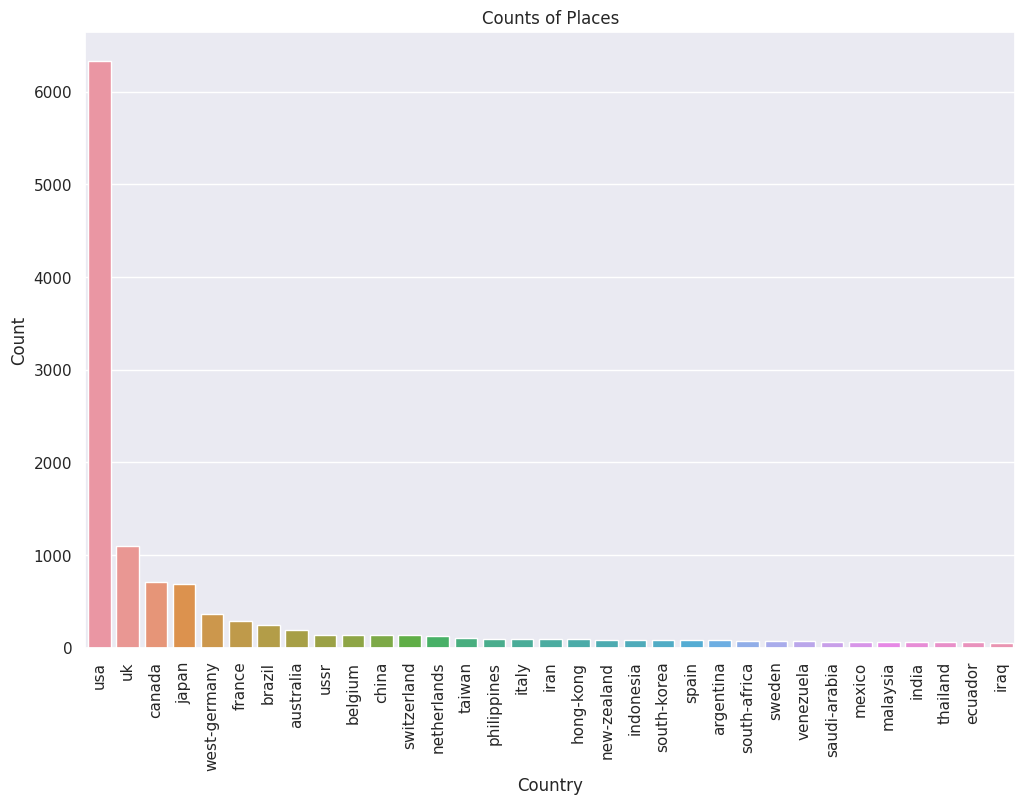

In [76]:
plt.figure(figsize=(12, 8))
sns.barplot(x=country_counts.index, y=country_counts.values)
plt.title('Counts of Places')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [77]:
# Initialize the label encoder
label_encoder = LabelEncoder()
# Fit and transform the categorical variable
encoded_categories = label_encoder.fit_transform(df['city'])
# Add the encoded categories as a new column in the dataframe
df['city_encoded'] = encoded_categories

In [78]:
# Extract datetime components
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['second'] = df['date'].dt.second

In [79]:
# Concatenate places & df
df = pd.concat([df,encoded_countries], axis=1)

In [80]:
df = df.drop(['places','city','date'],axis=1)

In [81]:
df.head()

,city_encoded,year,month,day,hour,minute,second,argentina,australia,belgium,...,spain,sweden,switzerland,taiwan,thailand,uk,usa,ussr,venezuela,west-germany
0,230,1987,2,26,15,10,44,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,36,1987,2,26,15,14,36,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,151,1987,2,26,15,15,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,182,1987,2,26,15,17,11,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,49,1987,2,26,15,19,15,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [82]:
df = df.drop(['hour','minute','second'],axis=1)

# Data Normalization

In [83]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Perform min-max normalization
x = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
x.head()

,city_encoded,year,month,day,argentina,australia,belgium,brazil,canada,china,...,spain,sweden,switzerland,taiwan,thailand,uk,usa,ussr,venezuela,west-germany
0,0.942623,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.147541,0.0,0.0,0.833333,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.618852,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.745902,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.200820,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [84]:
x = pd.concat([x, text_data], axis=1)
x.shape

(10419, 24194)

In [85]:
x.head()

,city_encoded,year,month,day,argentina,australia,belgium,brazil,canada,china,...,zoran,zorinski,zuccherifici,zuckerman,zuercher,zuheir,zulia,zurich,zverev,zwermann
0,0.942623,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.147541,0.0,0.0,0.833333,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.618852,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.745902,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.200820,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Multilabel Regression Model 

In [86]:
# Split your data into the input features (X) and the target variables (y)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,shuffle=True)

In [87]:
# logictic Regression
# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())
# train
classifier.fit(X_train, y_train)
# predict
predictions = classifier.predict(X_test)
# Accuracy
accuracy = accuracy_score(y_test, predictions) * 100
print("Accuracy : {:.2f}".format(accuracy),"%")

Accuracy : 84.12 %


# processing the topics for the ML phase

One drawback of multiclass classification is that it requires a certain threshold for the number of classes for cross-validation and the train-test split.

In [88]:
# changing the multilabels in topics to only one by making evry inner list in the topics only contain the first item ,
clean_topics_listed_form = []
for inner_list in clean_topics:
    temp_list = []
    temp_list.append(inner_list[0])
    clean_topics_listed_form.append(temp_list)

In [89]:
# Redoing the one hot encoder
# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# Perform one-hot encoding
topics_for_ML = mlb.fit_transform(clean_topics_listed_form)
# Create a new DataFrame with the encoded countries
y = pd.DataFrame(topics_for_ML, columns=mlb.classes_)
y.head()

,Unknown,acq,alum,austdlr,barley,bop,carcass,cocoa,coconut,coffee,...,sugar,tapioca,tea,tin,trade,veg-oil,wheat,wpi,yen,zinc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
# checking the multilabel
rowSums = y.sum(axis=1)
multiLabel_counts = rowSums.value_counts().iloc[1:]
print('number of lables for each article\n',rowSums,'\n')
print('number of articles have multilabel\n',multiLabel_counts)

number of lables for each article
 0        1
1        1
2        1
3        1
4        1
        ..
10414    1
10415    1
10416    1
10417    1
10418    1
Length: 10419, dtype: int64 

number of articles have multilabel
 Series([], Name: count, dtype: int64)


In [91]:
# changing the list structure of the topics to just text
clean_topics_singalText_form =[]
for inner_list in clean_topics_listed_form:
    # Join the items of the inner list into a single string
    concatenated_string = ' '.join(inner_list)
    clean_topics_singalText_form.append(concatenated_string)

In [92]:
df_for_ML['topics']=clean_topics_singalText_form
df_for_ML[['topics']] = df_for_ML[['topics']].applymap(clean_text)
df_for_ML.head()

,topics,article
0,grain,agricultur depart report reserv nation averag ...
1,veg-oil,argentin grain board figur show crop registr g...
2,Unknown,moodi investor servic inc said lower debt pref...
3,earn,champion product inc said board director appro...
4,earn,ohio mattress co said first quarter end februa...


In [93]:
# using Counter to find frequency of elements
frequency = collections.Counter(list(df_for_ML['topics']))
sorted_frequency =  sorted(frequency.items(), key=operator.itemgetter(1), reverse=True)

print(dict(sorted_frequency))

{'earn': 2709, 'acq': 1809, 'Unknown': 1786, 'money-fx': 542, 'grain': 460, 'crude': 447, 'trade': 421, 'interest': 251, 'ship': 176, 'sugar': 132, 'coffee': 112, 'money-supply': 109, 'gnp': 108, 'gold': 107, 'veg-oil': 83, 'oilseed': 74, 'cpi': 67, 'copper': 58, 'livestock': 54, 'reserves': 49, 'cocoa': 49, 'ipi': 46, 'jobs': 46, 'bop': 46, 'iron-steel': 45, 'nat-gas': 41, 'alum': 41, 'rubber': 38, 'dlr': 36, 'tin': 31, 'gas': 30, 'carcass': 26, 'cotton': 24, 'pet-chem': 24, 'wpi': 24, 'meal-feed': 21, 'wheat': 19, 'retail': 19, 'lead': 19, 'zinc': 18, 'strategic-metal': 17, 'housing': 16, 'heat': 16, 'silver': 16, 'hog': 16, 'orange': 15, 'lumber': 13, 'lei': 12, 'fuel': 12, 'tea': 9, 'corn': 7, 'income': 6, 'instal-debt': 5, 'potato': 5, 'nickel': 5, 'yen': 5, 'soybean': 4, 'platinum': 4, 'stg': 4, 'propane': 3, 'jet': 3, 'palm-oil': 3, 'l-cattle': 2, 'inventories': 2, 'cpu': 2, 'coconut': 2, 'rapeseed': 2, 'groundnut': 2, 'plywood': 2, 'rice': 2, 'f-cattle': 2, 'fishmeal': 1, 'tapi

In [94]:
# making a list of the items that have frequency equall to or more than 15 , whcih is the first 46 topics
top_46_topics =[]
for i,item in enumerate(sorted_frequency,start=1):
    if i<=46 :
        top_46_topics.append(item[0])

# One-hot encoding

In [95]:
# reducing the number of topics to 46
print("data frame lenth:",len(df_for_ML['topics']),",number of topics\n",len(unique(df_for_ML['topics'])),"\n")

df_for_ML_temp = df_for_ML
for index,item in enumerate(df_for_ML_temp["topics"]):
    if item not in top_46_topics:
        df_for_ML_temp = df_for_ML_temp.drop(df_for_ML.index[index])
df_for_ML=df_for_ML_temp

print("\ndata frame lenth:",len(df_for_ML['topics']),",number of topics\n",len(unique(df_for_ML['topics'])))

data frame lenth: 10419 ,number of topics
 79 


data frame lenth: 10293 ,number of topics
 46


# ML Model

In [96]:
# Split the data into inputs (articles) and targets (topics)
X = df_for_ML['article'].values
y = df_for_ML['topics'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and pad the article text sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding

max_seq_length = max(max(len(seq) for seq in X_train_seq), max(len(seq) for seq in X_test_seq))

X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length)

In [97]:
# Encode the target data
num_classes = 46  # Number of target classes

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
# One-hot encoding
y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes)

In [98]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_seq_length))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(46, activation='softmax'))  

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [99]:
model.fit(X_train_padded,y_train_one_hot,epochs=10,batch_size=32,validation_data=(X_test_padded, y_test_one_hot))

Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 233s 888ms/step - accuracy: 0.3564 - loss: 2.5614 - val_accuracy: 0.5119 - val_loss: 1.7625
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 227s 881ms/step - accuracy: 0.5415 - loss: 1.6231 - val_accuracy: 0.5527 - val_loss: 1.6998
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 262s 881ms/step - accuracy: 0.6004 - loss: 1.3826 - val_accuracy: 0.6382 - val_loss: 1.3584
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 264s 889ms/step - accuracy: 0.6959 - loss: 1.1126 - val_accuracy: 0.6965 - val_loss: 1.1567
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 261s 887ms/step - accuracy: 0.7477 - loss: 0.9233 - val_accuracy: 0.7358 - val_loss: 0.9798
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 229s 887ms/step - accuracy: 0.7821 - loss: 0.7518 - val_accuracy: 0.7494 - val_loss: 0.9444
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 260s 881ms/step - accuracy: 0.8384 - loss: 0.5651 - val_accuracy: 0.7538 - val_loss: 0.8944
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 227s 881ms/step - accuracy: 0.8650 -

In [100]:
loss,acc =model.evaluate(X_test_padded,y_test_one_hot)

65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - accuracy: 0.8053 - loss: 0.8319
